# DBLP数据挖掘
1120201928 张传龙
## 数据获取与数据预处理
#### 数据获取:从官网下载最新的DBLP数据集

In [ ]:
!pip install requests

In [ ]:
import requests
import gzip
import shutil

# 定义要下载的文件 URL
url = "https://dblp.org/xml/dblp.xml.gz"
# 定义保存的文件名
output_file = "dblp.xml"

# 发送 GET 请求并保存响应
response = requests.get(url, stream=True)
if response.status_code == 200:
    # 将响应的内容写入文件
    with open(output_file + ".gz", 'wb') as f:
        f.write(response.content)
    print("Downloaded gzip file successfully.")
else:
    print("Failed to download gzip file.")

Downloaded gzip file successfully.


In [ ]:
!pwd

/content
/content


#### 查看当前文件夹

#### 解压文件

In [ ]:
with gzip.open(output_file + ".gz", 'rb') as f_in:
    with open(output_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
print("Extracted gzip file successfully.")

Extracted gzip file successfully.


### 数据结构
##### 我们知道数据集的结构如下所示

```
<?xml version="1.0" encoding="ISO-8859-1"?>
<!DOCTYPE dblp SYSTEM "dblp.dtd">
<dblp>
    <article mdate="2017-05-28" key="journals/acta/Saxena96">
        <author>Sanjeev Saxena</author>
        <title>Parallel Integer Sorting and Simulation Amongst CRCW Models.</title>
        <pages>607-619</pages>
        <year>1996</year>
        <volume>33</volume>
        <journal>Acta Inf.</journal>
        <number>7</number>
        <url>db/journals/acta/acta33.html#Saxena96</url>
        <ee>https://doi.org/10.1007/BF03036466</ee>
    </article>

......
<dblp>
```
- 其中包含了每个文章的作者，题目，页码，发表年份等内容，所有属性如下所示
  - author、title、pages、year、volume、journal、number、url、ee

### 数据预处理

- 我们的目的是对作者这个属性进行频繁模式和关联规则挖掘，所以对数据集中的作者条目进行了预处理生成新的文件方便下一步的工作
- 作者可能一起发表论文，一起写书等，所以paper_tag有很多个值




In [ ]:
from xml.sax import handler, make_parser
import codecs
import time
import numpy as np
import pandas as pd
# 包含作者的标签
paper_tag = ('article','inproceedings','proceedings','book','incollection','phdthesis','mastersthesis','www')

class mHandler(handler.ContentHandler):
    def __init__(self,result):
        self.result = result
        self.flag = 0

    def startDocument(self):
        print('Document Start...')

    def endDocument(self):
        print('Document End...')

    def startElement(self, name, attrs):
        if name == 'author':
            self.flag = 1

    def endElement(self, name):
        if name == 'author':
            self.result.write(',')
            self.flag = 0
        if (name in paper_tag) :
            self.result.write('\r\n')

    def characters(self, chrs):                                 # [8]
        if self.flag:
            self.result.write(chrs)

def parserDblpXml(source,result):
    handler = mHandler(result)
    parser = make_parser()
    parser.setContentHandler(handler)

    parser.parse(source)




In [ ]:
source = codecs.open('./dblp.xml','r','utf-8')
result = codecs.open('./authors.txt','w','utf-8')
parserDblpXml(source,result)
result.close()
source.close()

Document Start...
Document End...


## 频繁模式挖掘
- 挖掘频繁模式项藉，我们挖掘的时文章的共同作者，我们将这个模型命名为合作模式
- 我们使用mlxtend中的Apriori包实现关联规则挖掘，在使用这个包之前，我们需要先将数据编码为one-hot的形式

In [ ]:
source = codecs.open('./authors.txt','r','utf-8')
result = codecs.open('./authors_one_hot.txt','w','utf-8')
index = codecs.open('./authors_index.txt','w','utf-8')
index_dic = {}   #字典记录one-hot编码与作者名字的对应关系
id = 0

for line in source:
    name_list = line.split(',')
    for name in name_list:
        if not (name == '\r\n'):
            if name in index_dic:
                index_dic[name][1] +=1  #计数
            else:
                index_dic[name] = [id,1]
                index.write(name + u'\r\n')
                id += 1
            result.write(str(index_dic[name][0]) + u',') # authors_encoded.txt
    result.write('\r\n')

source.close()
result.close()
index.close()

- 计算每个作者的support，进一步得到每个support下的作者数量并且将其可视化，这有助于进一步的工作

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
data = codecs.open('./authors_one_hot.txt','r','utf-8')
word_counts = {}  # 记录每个作者出现的次数
maxCounts = 0

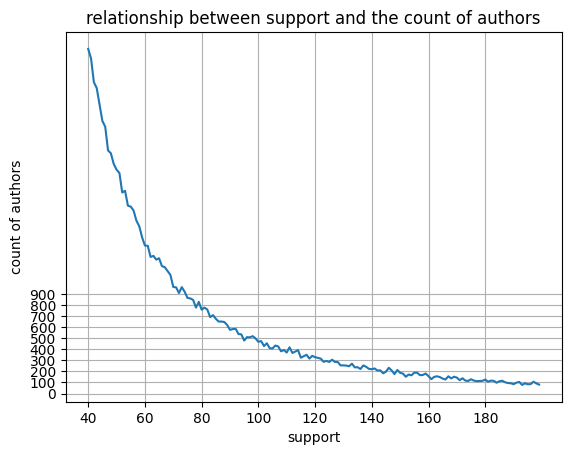

In [ ]:
for line in data:
    line = line.split(',')
    for word in line[0:-1]:
        word_counts[word] = word_counts.get(word,0) + 1
        if word_counts[word] > maxCounts:
            maxCounts = word_counts[word]
            maxKey = word

xMax = maxCounts
data.close()

#key->support,value=>author_count
bins = {}
for k,v in word_counts.items():
    bins[v] = bins.get(v,0) + 1

y = []
for i in range(40,200):
    y.append(bins.get(i,0))

plt.plot(y,'-');
plt.grid()
plt.yticks(range(0,1000,100))
plt.xticks(range(0,160,20),range(40,200,20))
plt.xlabel('support')
plt.ylabel('count of authors')
plt.show()

从图中大概可以看出，作者数量和支持度大概成反比，支持度越大，对应的作者数量越少。这是显然的，能够发很多论文的人是占少数的
## 频繁挖掘
- 我们使用Mlxtend包里的Apriori算法进行了关联规则的挖掘，因为数据集比较大，所以我们只使用前30000条数据集进行挖掘
- 首先我们安装mlxtend包

In [ ]:
!pip install mlxtend

In [ ]:
!pip install scipy

### 设置参数
- 我们设置使用的数据集数量为30000，最小支持度为10，最小置信度为0.5来进行关联规则的挖掘

In [ ]:
dataLen=30000
minSup=10
min_con=0.5

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#### 定义加数数据的函数，方便后续代码的编写

In [ ]:
def loadData(inFile):
    dataSet = []
    for line in inFile:
        line = line.strip().split(',')
        dataLine = [int(word) for word in line if word.isdigit()]
        dataSet.append(dataLine)
    return dataSet

#### 对数据集进行处理，将顺序编码转化为one-hot编码，这样才能够直接使用库中的算法

In [ ]:
from scipy import sparse
import pandas as pd
with open('./authors_one_hot.txt', 'r') as f:
    f_lines = list(line for line in (l.strip() for l in f) if line)  # 去除空行
    dataSet = loadData(f_lines)

data = dataSet[0:dataLen]


#转化为One-Hot编码
te = TransactionEncoder()
te_ary = te.fit(data).transform(data, sparse=True)
sparse_matrix = sparse.csr_matrix(te_ary)
sparse_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns=te.columns_)
te_len = te_ary.shape[0]


In [ ]:
# 生成频繁项集
frequent_itemsets = apriori(sparse_df, min_support=minSup/te_len, use_colnames=True)

In [ ]:
print(frequent_itemsets)

      support               itemsets
0    0.000900                   (10)
1    0.000333                   (36)
2    0.000400                   (37)
3    0.000400                  (206)
4    0.001333                  (858)
..        ...                    ...
375  0.000433         (43923, 43955)
376  0.000367         (44560, 44561)
377  0.000400   (14417, 14418, 2110)
378  0.000533   (11704, 7854, 11830)
379  0.000400  (31920, 31921, 31919)

[380 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 频繁项藉的如上所示，可以看到在三万条数据集内可以找到一些两人或者三人的合作团队，不过频繁项藉没有以作者名字来展示，而是以作者的顺序编号展示

#### 绘制频繁项集的条形图（仅显示最高频率的十个项集）

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


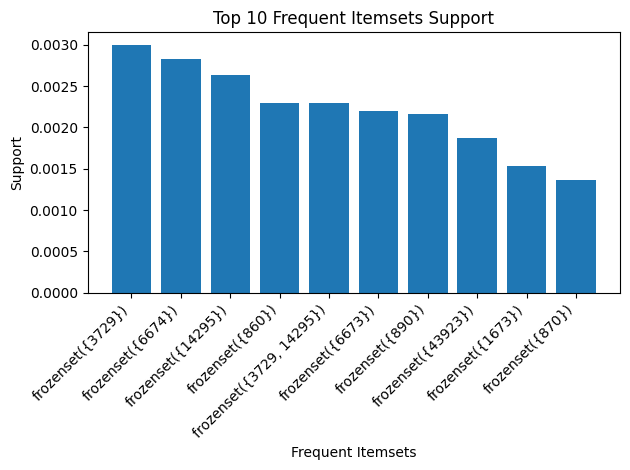

In [ ]:

top_10_frequent_itemsets = frequent_itemsets.nlargest(10, 'support')
plt.bar(range(len(top_10_frequent_itemsets)), top_10_frequent_itemsets['support'])
plt.xticks(range(len(top_10_frequent_itemsets)), top_10_frequent_itemsets['itemsets'], rotation=45, ha='right')
plt.xlabel('Frequent Itemsets')
plt.ylabel('Support')
plt.title('Top 10 Frequent Itemsets Support')
plt.tight_layout()
plt.show()

#### 前十的项藉我们可以看到大多都是单人的团队，排在第五位的是一个双人团队

In [ ]:
with open('./authors_index.txt','r') as authorsIndex:
    i = 0
    authorsDic = {}
    for name in authorsIndex:
        name = name.strip()
        authorsDic[i] = name
        i = i+1

#### 使用其中的算法进行关联规则的挖掘

In [ ]:
rules = association_rules(frequent_itemsets, min_threshold=min_con)

In [ ]:
ant_author = []
con_author = []

for index, row in rules.iterrows():
    a_list = []
    c_list = []

    antecedents = row['antecedents']
    consequents = row['consequents']
    for a in antecedents:
        authorA = authorsDic.get(int(a), '0')
        a_list.append(authorA)
    ant_author.append(a_list)

    for c in consequents:
        authorC = authorsDic.get(int(c), '0')
        c_list.append(authorC)
    con_author.append(c_list)

In [ ]:
rules['ant_author'] = ant_author
rules['con_author'] = con_author

In [ ]:
print(rules)

       antecedents     consequents  antecedent support  consequent support  \
0             (36)            (37)            0.000333            0.000400   
1             (37)            (36)            0.000400            0.000333   
2            (864)           (968)            0.000900            0.000700   
3            (968)           (864)            0.000700            0.000900   
4            (933)           (934)            0.000733            0.000733   
..             ...             ...                 ...                 ...   
80  (31920, 31919)         (31921)            0.000400            0.000467   
81  (31921, 31919)         (31920)            0.000400            0.000400   
82         (31920)  (31921, 31919)            0.000400            0.000400   
83         (31921)  (31920, 31919)            0.000467            0.000400   
84         (31919)  (31920, 31921)            0.000400            0.000400   

     support  confidence         lift  leverage  conviction  zh

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- 简单保存一下挖掘结果

In [ ]:
rules.to_csv('./dblp_result_' + str(dataLen) + '_' + str(minSup) + '_' + str(min_con) + '.csv', index=False)

### 下边将结果进行简单的可视化

### 关联规则支持度和置信度

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


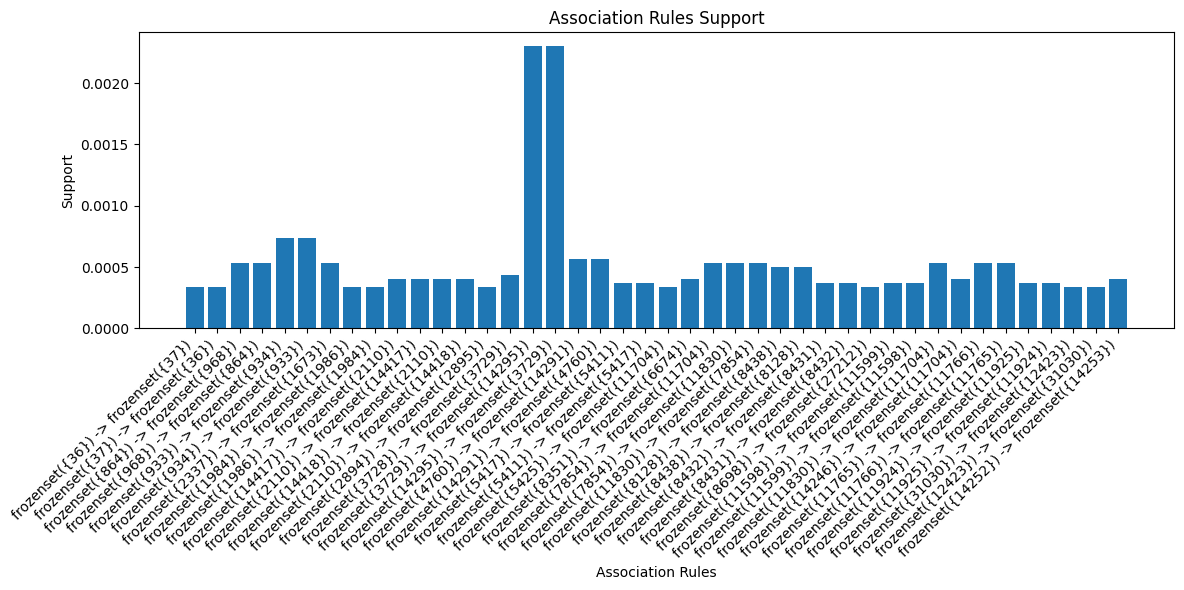

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取保存的CSV文件
result_file = './dblp_result_' + str(dataLen) + '_' + str(minSup) + '_' + str(min_con) + '.csv'
df = pd.read_csv(result_file)

# 仅展示一半数据
half_len = len(df) // 2
df = df[:half_len]

# 绘制柱状图示例：关联规则支持度和置信度
plt.figure(figsize=(12, 6))
plt.bar(range(len(df)), df['support'], tick_label=df['antecedents'].astype(str) + ' -> ' + df['consequents'].astype(str))
plt.xlabel('Association Rules')
plt.ylabel('Support')
plt.title('Association Rules Support')
plt.xticks(rotation=45, ha='right')  # 旋转X轴标签并向右对齐
plt.subplots_adjust(bottom=0.3, wspace=0.5)  # 调整子图布局，增加水平间距
plt.tight_layout()
plt.show()

#### 可视化关联规则的支持度和置信度散点图

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


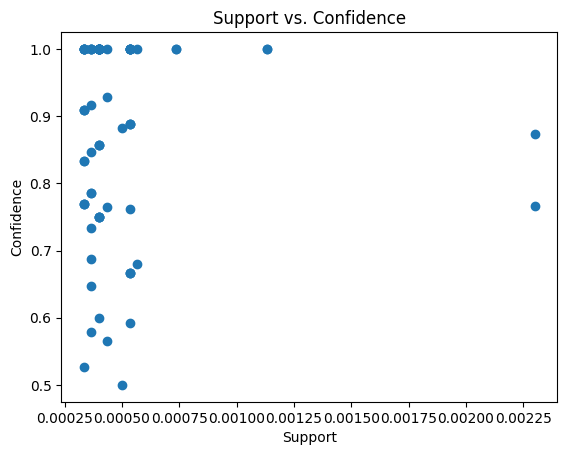

In [ ]:
plt.scatter(rules['support'], rules['confidence'])
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs. Confidence')
plt.show()

#### 可以看到点都聚集在支持度较低的位置，而置信度在0.5到1之间均匀分布，有两个点在支持度0.00225右侧

#### 可视化关联规则的网络图

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-28-29373e90d8a5>:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_edges = random.sample(G.edges(), num_edges)


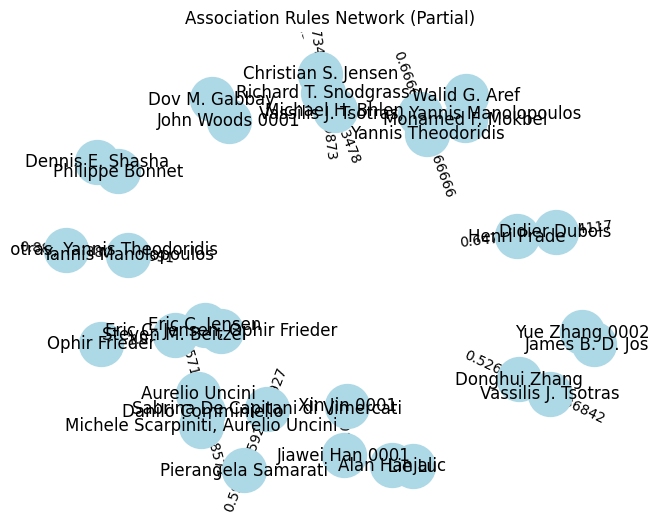

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import random


num_edges = 20
selected_edges = random.sample(G.edges(), num_edges)


subgraph = G.edge_subgraph(selected_edges)


pos = nx.spring_layout(subgraph)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw(subgraph, pos, with_labels=True, node_size=1000, node_color='lightblue', edge_color='gray')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)
plt.title('Association Rules Network (Partial)')
plt.show()

- 从图中可以看到根据我们的算法计算出的一些团队，当两个圆形重合部分比较大的时候说明这两个作者是一个团队的可能性很大